In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from numba import njit
import time


plt.rcParams.update({
    'font.size': 14,
    'axes.titlesize': 16,
    'axes.labelsize': 14,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12,
    'legend.fontsize': 12,
    'figure.figsize': (14, 10)
})

@njit
def simulate_ising_lattice(size, temperature, steps, seed):
    np.random.seed(seed)
    lattice = np.ones((size, size), dtype=np.int8)
    for _ in range(steps):
        i = np.random.randint(size)
        j = np.random.randint(size)
        spin = lattice[i, j]
        neighbors = (lattice[(i-1)%size, j] + lattice[(i+1)%size, j] +
                     lattice[i, (j-1)%size] + lattice[i, (j+1)%size])
        energy_change = 2 * spin * neighbors
        if energy_change <= 0 or np.random.rand() < np.exp(-energy_change / temperature):
            lattice[i, j] = -spin
    return lattice

def compute_magnetization(lattice):
    return abs(np.mean(lattice))

def compute_energy_per_site(lattice, size):
    energy = 0
    for i in range(size):
        for j in range(size):
            spin = lattice[i, j]
            neighbors = (lattice[(i-1)%size, j] + lattice[(i+1)%size, j] +
                         lattice[i, (j-1)%size] + lattice[i, (j+1)%size])
            energy -= spin * neighbors
    return energy / (2 * size * size)

Generating reference configurations...


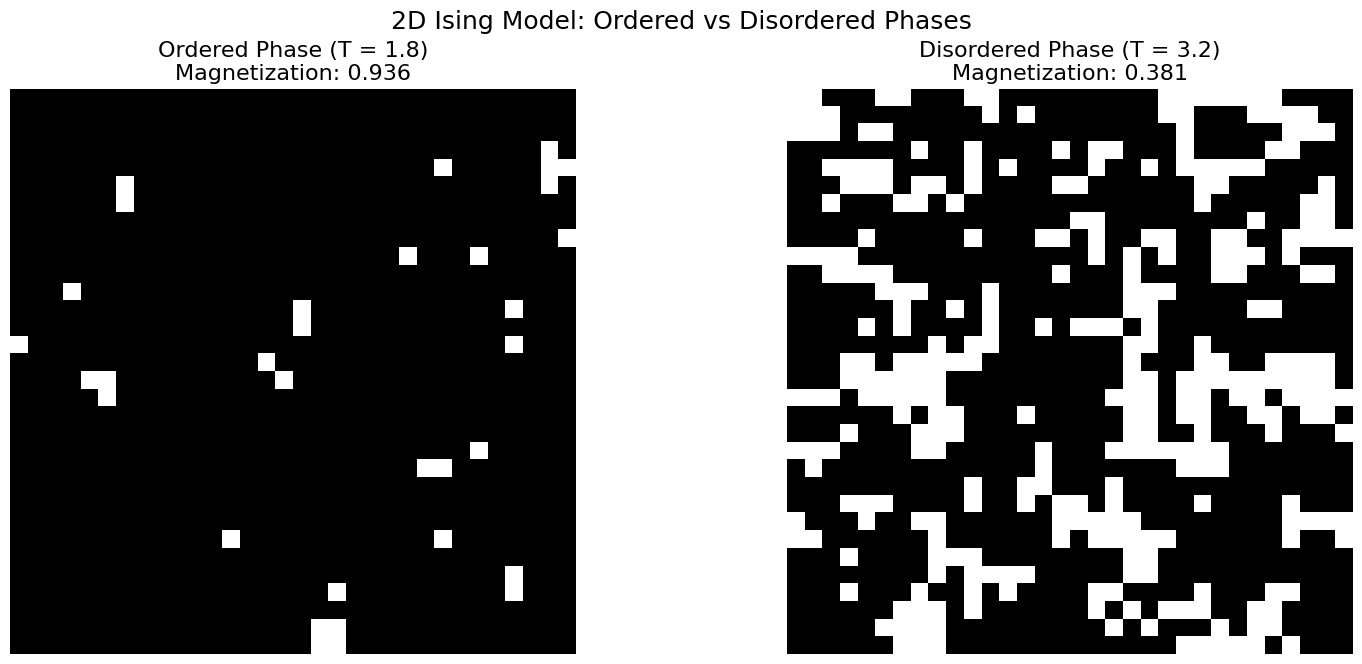

Energy/site (ordered): -0.0430
Energy/site (disordered): -0.0156


/tmp/ipython-input-2862821469.py:49: RuntimeWarning: overflow encountered in scalar subtract
  energy -= spin * neighbors


In [5]:
L = 32
T_ordered = 1.8
T_disordered = 3.2
equilibration_steps_ordered = 12000
equilibration_steps_disordered = 5000

print("Generating reference configurations...")
start_time = time.time()

ordered_example = simulate_ising_lattice(L, T_ordered, equilibration_steps_ordered, seed=100)
disordered_example = simulate_ising_lattice(L, T_disordered, equilibration_steps_disordered, seed=200)


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 7))
ax1.imshow(ordered_example, cmap='binary', vmin=-1, vmax=1)
ax1.set_title(f'Ordered Phase (T = {T_ordered})\nMagnetization: {compute_magnetization(ordered_example):.3f}')
ax1.axis('off')

ax2.imshow(disordered_example, cmap='binary', vmin=-1, vmax=1)
ax2.set_title(f'Disordered Phase (T = {T_disordered})\nMagnetization: {compute_magnetization(disordered_example):.3f}')
ax2.axis('off')

plt.suptitle('2D Ising Model: Ordered vs Disordered Phases', fontsize=18, y=0.95)
plt.tight_layout()
plt.show()

print(f"Energy/site (ordered): {compute_energy_per_site(ordered_example, L):.4f}")
print(f"Energy/site (disordered): {compute_energy_per_site(disordered_example, L):.4f}")

In [3]:
samples_per_phase = 800
print(f"\nGenerating {2 * samples_per_phase} training samples...")

X_ordered = np.stack([
    simulate_ising_lattice(L, T_ordered, equilibration_steps_ordered, seed=i)
    for i in range(samples_per_phase)
])
X_disordered = np.stack([
    simulate_ising_lattice(L, T_disordered, equilibration_steps_disordered, seed=i + samples_per_phase)
    for i in range(samples_per_phase)
])

X = np.concatenate([X_ordered, X_disordered])[:, :, :, np.newaxis]
y = np.array([0] * samples_per_phase + [1] * samples_per_phase)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(L, L, 1), padding='same'),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.3),
    Dense(128, activation='relu'),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

print("\nTraining CNN classifier...")
history = model.fit(X_train, y_train, epochs=15, batch_size=32, validation_split=0.15, verbose=1)

test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f"\nFinal Test Accuracy: {test_accuracy:.4f}")


Generating 1600 training samples...

Training CNN classifier...
Epoch 1/15


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


34/34 ━━━━━━━━━━━━━━━━━━━━ 4s 54ms/step - accuracy: 0.8585 - loss: 0.2519 - val_accuracy: 1.0000 - val_loss: 7.6591e-13
Epoch 2/15
34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 55ms/step - accuracy: 1.0000 - loss: 2.4299e-16 - val_accuracy: 1.0000 - val_loss: 2.5123e-20
Epoch 3/15
34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - accuracy: 1.0000 - loss: 2.3442e-16 - val_accuracy: 1.0000 - val_loss: 1.2331e-20
Epoch 4/15
34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 53ms/step - accuracy: 1.0000 - loss: 6.9784e-17 - val_accuracy: 1.0000 - val_loss: 1.2038e-20
Epoch 5/15
34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 47ms/step - accuracy: 1.0000 - loss: 7.9440e-16 - val_accuracy: 1.0000 - val_loss: 1.2033e-20
Epoch 6/15
34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 69ms/step - accuracy: 1.0000 - loss: 2.3181e-18 - val_accuracy: 1.0000 - val_loss: 1.2033e-20
Epoch 7/15
34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - accuracy: 1.0000 - loss: 2.1370e-16 - val_accuracy: 1.0000 - val_loss: 1.2033e-20
Epoch 8/15
34/34 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step - accuracy: 1.0000 


Scanning temperature range for phase transition...


/tmp/ipython-input-2862821469.py:49: RuntimeWarning: overflow encountered in scalar subtract
  energy -= spin * neighbors


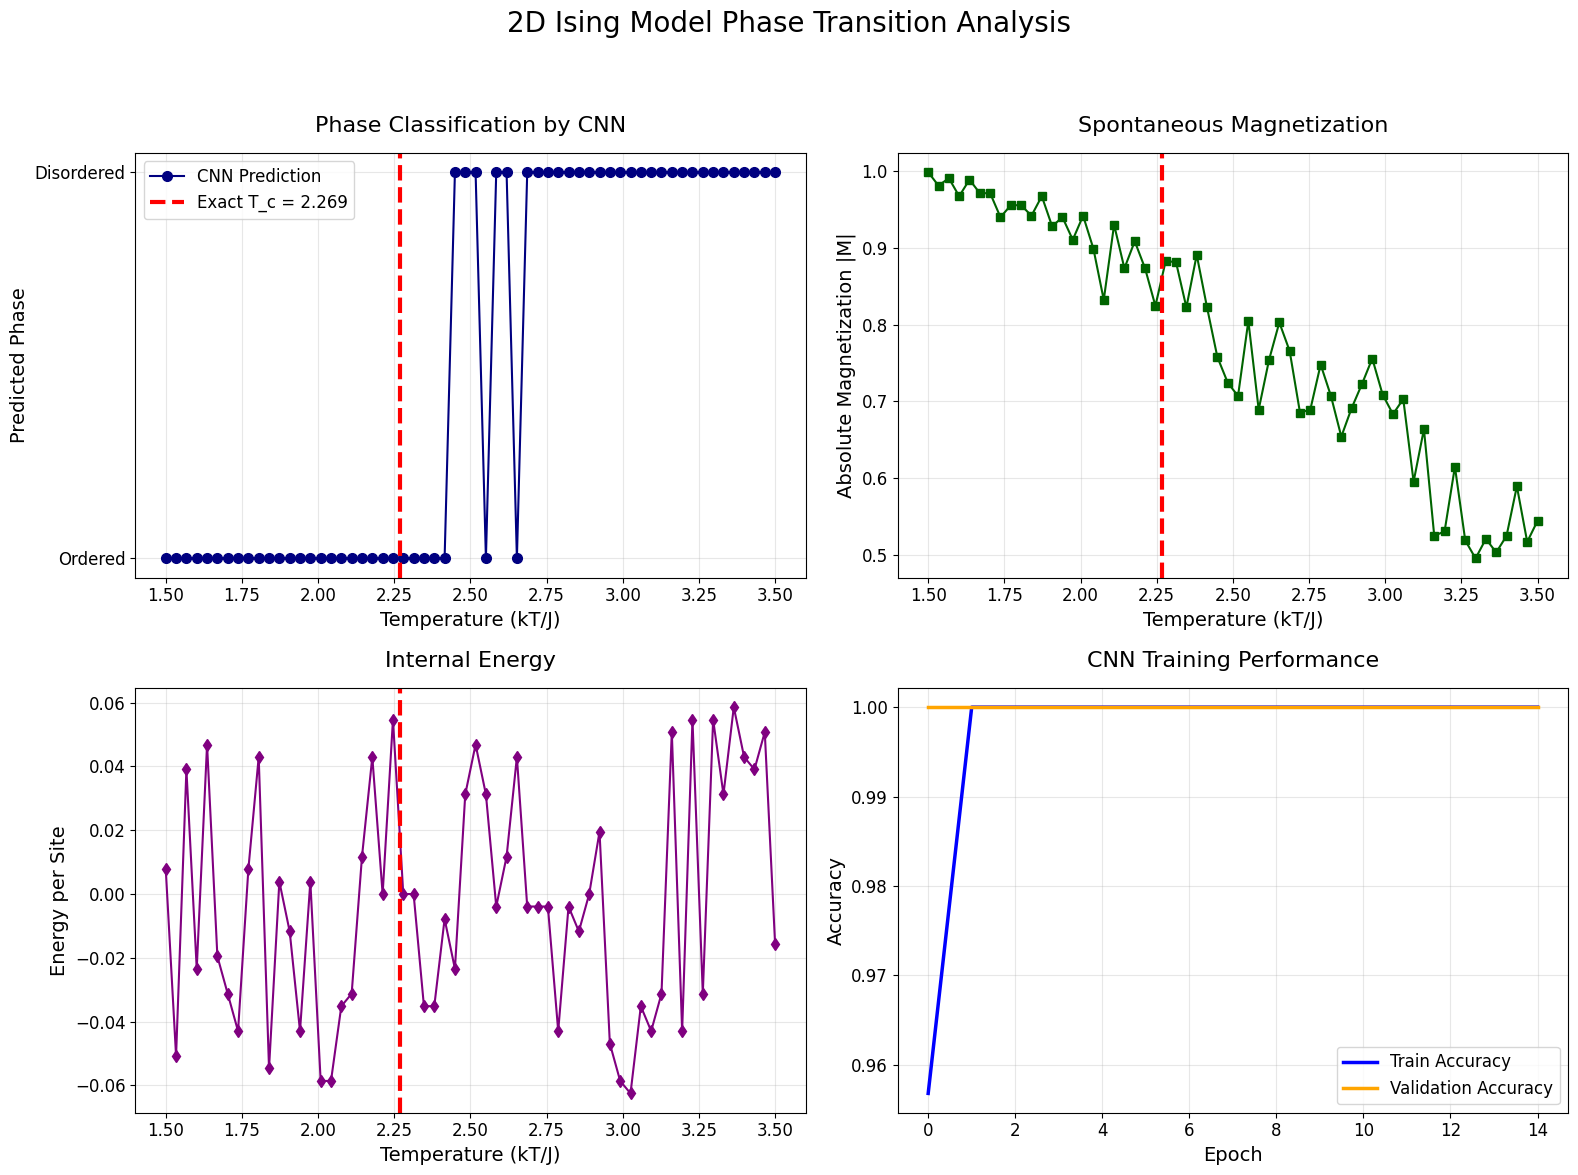


Critical Point Analysis (T = 2.269):
  CNN Probability (Disordered): 0.0000
  Magnetization: 0.8301

Project completed in 49.4 seconds.


In [7]:
temperature_scan_points = 60
scan_steps_low = 10000
scan_steps_mid = 6000
scan_steps_high = 4000

print("\nScanning temperature range for phase transition...")
temperatures = np.linspace(1.5, 3.5, temperature_scan_points)
predicted_phases = []
magnetizations = []
energies = []

for idx, T in enumerate(temperatures):
    steps = scan_steps_low if T <= 2.1 else scan_steps_mid if T <= 2.6 else scan_steps_high
    lattice = simulate_ising_lattice(L, T, steps, seed=idx + 1000)
    prob = model.predict(lattice[np.newaxis, :, :, np.newaxis], verbose=0)[0, 0]
    phase = 1 if prob > 0.5 else 0
    mag = compute_magnetization(lattice)
    energy = compute_energy_per_site(lattice, L)

    predicted_phases.append(phase)
    magnetizations.append(mag)
    energies.append(energy)


plt.figure(figsize=(16, 12))


plt.subplot(2, 2, 1)
plt.plot(temperatures, predicted_phases, 'o-', color='navy', markersize=7, label='CNN Prediction')
plt.axvline(2.269, color='red', linestyle='--', linewidth=3, label='Exact T_c = 2.269')
plt.xlabel('Temperature (kT/J)')
plt.ylabel('Predicted Phase')
plt.yticks([0, 1], ['Ordered', 'Disordered'])
plt.title('Phase Classification by CNN', fontsize=16, pad=15)
plt.legend()
plt.grid(True, alpha=0.3)


plt.subplot(2, 2, 2)
plt.plot(temperatures, magnetizations, 's-', color='darkgreen', markersize=6)
plt.axvline(2.269, color='red', linestyle='--', linewidth=3)
plt.xlabel('Temperature (kT/J)')
plt.ylabel('Absolute Magnetization |M|')
plt.title('Spontaneous Magnetization', fontsize=16, pad=15)
plt.grid(True, alpha=0.3)


plt.subplot(2, 2, 3)
plt.plot(temperatures, energies, 'd-', color='purple', markersize=6)
plt.axvline(2.269, color='red', linestyle='--', linewidth=3)
plt.xlabel('Temperature (kT/J)')
plt.ylabel('Energy per Site')
plt.title('Internal Energy', fontsize=16, pad=15)
plt.grid(True, alpha=0.3)


plt.subplot(2, 2, 4)
plt.plot(history.history['accuracy'], label='Train Accuracy', color='blue', linewidth=2.5)
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='orange', linewidth=2.5)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('CNN Training Performance', fontsize=16, pad=15)
plt.legend()
plt.grid(True, alpha=0.3)

plt.suptitle('2D Ising Model Phase Transition Analysis', fontsize=20, y=0.98)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


critical_temp = 2.269
critical_lattice = simulate_ising_lattice(L, critical_temp, 8000, seed=999)
critical_prob = model.predict(critical_lattice[np.newaxis, :, :, np.newaxis], verbose=0)[0, 0]
critical_mag = compute_magnetization(critical_lattice)

print(f"\nCritical Point Analysis (T = {critical_temp}):")
print(f"  CNN Probability (Disordered): {critical_prob:.4f}")
print(f"  Magnetization: {critical_mag:.4f}")


total_time = time.time() - start_time
print(f"\nProject completed in {total_time:.1f} seconds.")